In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/Progetto_Neuro/Modello/Finale/data_loader.py .
!cp /content/drive/MyDrive/Progetto_Neuro/NEUROENGINEERING_AY2425_PW07_GROUP03/classic_MLP.py .

cp: cannot stat '/content/drive/MyDrive/Progetto_Neuro/Modello/Finale/data_loader.py': No such file or directory


In [3]:
!pip install tensorboardX
!pip install --upgrade efficientnet-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=21e939eb77c33fa408b1901829684e6ea4733c3b8cbffba52667378047c2670e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [4]:
import argparse

import torch
from torch import nn
from torch.utils.data import DataLoader
#from data_loader import AttentionDataset
from sklearn.metrics import multilabel_confusion_matrix
import os

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score


import random
import numpy as np

import pickle
import io
import copy

import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

import PIL.Image
from torchvision.transforms import ToTensor
from classic_MLP import MLP, CNN, MLP_CNN
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

##Data loading

In [5]:
import pandas as pd

headers_test = [
    'frame', 'confidence_azimuth', 'confidence_elevation', 'azimuth', 'elevation',
    'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'eyes_x', 'eyes_y',
    'use_robot', 'label', 'timestamp', 'patient'
]

headers = [
    'frame', 'confidence_azimuth', 'confidence_elevation', 'azimuth', 'elevation', 'coord_1', 'coord_2', 'coord_3',
    'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'eyes_x', 'eyes_y',
    'use_robot', 'label', 'timestamp', 'patient'
]


X_train_temp = pd.read_csv('/content/drive/MyDrive/Progetto_Neuro/Book_train_ch.csv', header=None, names=headers)

X_val_temp = pd.read_csv('/content/drive/MyDrive/Progetto_Neuro/Book_val_ch.csv', header=None, names=headers)

therapists_temp = pd.read_csv('/content/drive/MyDrive/Progetto_Neuro/Book_train_th.csv', header=None, names=headers)
therapists_val_temp=pd.read_csv('/content/drive/MyDrive/Progetto_Neuro/Book_val_th.csv', header=None, names=headers)
X_train_temp.head()

,frame,confidence_azimuth,confidence_elevation,azimuth,elevation,coord_1,coord_2,coord_3,bbox_x1,bbox_y1,bbox_x2,bbox_y2,eyes_x,eyes_y,use_robot,label,timestamp,patient
0,0,0.036028,0.036028,-0.391174,-0.112615,-0.045839,0.131920,2.706689,453,356,487,417,470.682831,377.739238,R,nowhere,1.732533e+09,LaCa_CH
1,5,0.038986,0.038986,-0.487759,-0.139655,-0.047601,0.143458,2.707428,453,356,487,417,470.526459,377.668658,R,nowhere,1.732533e+09,LaCa_CH
2,10,0.037485,0.037485,-0.395378,-0.141010,-0.046297,0.145592,2.709016,453,355,487,417,470.360626,377.333586,R,nowhere,1.732533e+09,LaCa_CH
3,15,0.041863,0.041863,-0.445813,-0.158037,-0.037552,0.148174,2.714356,451,354,485,416,468.732208,376.790257,R,nowhere,1.732533e+09,LaCa_CH
4,20,0.051062,0.051062,-0.530704,-0.133122,-0.004135,0.135274,2.714356,444,358,475,412,460.020447,377.561346,R,nowhere,1.732533e+09,LaCa_CH


In [6]:
X_test_temp = pd.read_csv('/content/drive/MyDrive/Progetto_Neuro/Modello/dataset_laura.txt', sep=',', header=None, skiprows=1, names=headers_test)
X_test_temp.head()


,frame,confidence_azimuth,confidence_elevation,azimuth,elevation,bbox_x1,bbox_y1,bbox_x2,bbox_y2,eyes_x,eyes_y,use_robot,label,timestamp,patient
0,0,0.386142,0.386142,-1.463393,-0.847300,342,362,377,420,359.673096,383.273769,WR,nowhere,1.701261e+09,DG01-T0
1,30,0.419124,0.419124,-1.705272,-0.775637,341,363,375,421,358.731476,383.954631,WR,giocattolo,1.701261e+09,DG01-T0
2,60,0.286879,0.286879,-1.647638,-1.213535,342,362,376,421,359.353699,383.486322,WR,giocattolo,1.701261e+09,DG01-T0
3,90,0.985331,0.985331,-0.699572,-0.768224,341,366,372,418,356.871948,385.021942,WR,giocattolo,1.701261e+09,DG01-T0
4,120,0.677928,0.677928,-1.262147,-0.446763,365,374,404,430,384.921173,394.146155,WR,altra_p,1.701261e+09,DG01-T0


###Split

In [7]:
X_train=X_train_temp.drop(columns=['label', 'confidence_elevation','bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2','coord_1', 'coord_2', 'coord_3', 'frame', 'timestamp'])
y_train=pd.DataFrame(X_train_temp['label'])

X_val=X_val_temp.drop(columns=['label', 'confidence_elevation','bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2','coord_1', 'coord_2', 'coord_3', 'frame', 'timestamp'])
y_val=pd.DataFrame(X_val_temp['label'])

X_test=X_test_temp.drop(columns=['label', 'confidence_elevation','bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'frame', 'timestamp'])
y_test=pd.DataFrame(X_test_temp['label'])

X_therapists=therapists_temp.drop(columns=['label', 'confidence_elevation','bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2','coord_1', 'coord_2', 'coord_3', 'frame', 'timestamp'])
y_therapists=pd.DataFrame(therapists_temp['label'])

X_therapists_val=therapists_val_temp.drop(columns=['label', 'confidence_elevation','bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2','coord_1', 'coord_2', 'coord_3', 'frame', 'timestamp'])
y_therapists_val=pd.DataFrame(therapists_val_temp['label'])


In [8]:
print(X_test['use_robot'].unique())

idx = X_test[X_test['use_robot'] == 'O'].index
X_test['use_robot'].iloc[idx] = 'WR'

print(X_test['use_robot'].unique())
idx = X_test[X_test['use_robot'] == 'O'].index
print(idx)


['WR' 'O' 'R']
['WR' 'R']
Index([], dtype='int64')


<ipython-input-8-519f3ce55186>:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X_test['use_robot'].iloc[idx] = 'WR'
<ipython-input-8-519f3ce55186>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [9]:

count = 0
patient = []
for i in range(0, len(y_train)):
  if X_train.iloc[i]['use_robot'] == 1:
    if y_train.iloc[i]['label'] == 'robot':
      count = count + 1
      #print(X_train.iloc[i])
      #print(y_train.iloc[i])
      patient.append(X_train.iloc[i]['patient'])

print(f'Train: {count}')

count = 0
patient = []
for i in range(0, len(y_val)):
  if X_val.iloc[i]['use_robot'] == 1:
    if y_val.iloc[i]['label'] == 'robot':
      count = count + 1
      #print(X_val.iloc[i])
      #print(y_val.iloc[i])
      patient.append(X_val.iloc[i]['patient'])
print(f'Val: {count}')

count = 0
patient = []
idx_problema = []
for i in range(0, len(y_test)):
  if X_test.iloc[i]['use_robot'] == 1:
    if y_test.iloc[i]['label'] == 'robot':
      count = count + 1
      idx_problema.append(i)
      #print(X_test.iloc[i])
      #print(y_test.iloc[i])
      patient.append(X_test.iloc[i]['patient'])
print(f'Test: {count}')

X_test = X_test.drop(index=idx_problema)
y_test = y_test.drop(index=idx_problema)

count = 0
patient = []
idx_problema = []
for i in range(0, len(y_test)):
  if X_test.iloc[i]['use_robot'] == 1:
    if y_test.iloc[i]['label'] == 'robot':
      count = count + 1
      idx_problema.append(i)
      #print(X_test.iloc[i])
      #print(y_test.iloc[i])
      patient.append(X_test.iloc[i]['patient'])
print(f'Test_new: {count}')


Train: 0
Val: 0
Test: 0
Test_new: 0


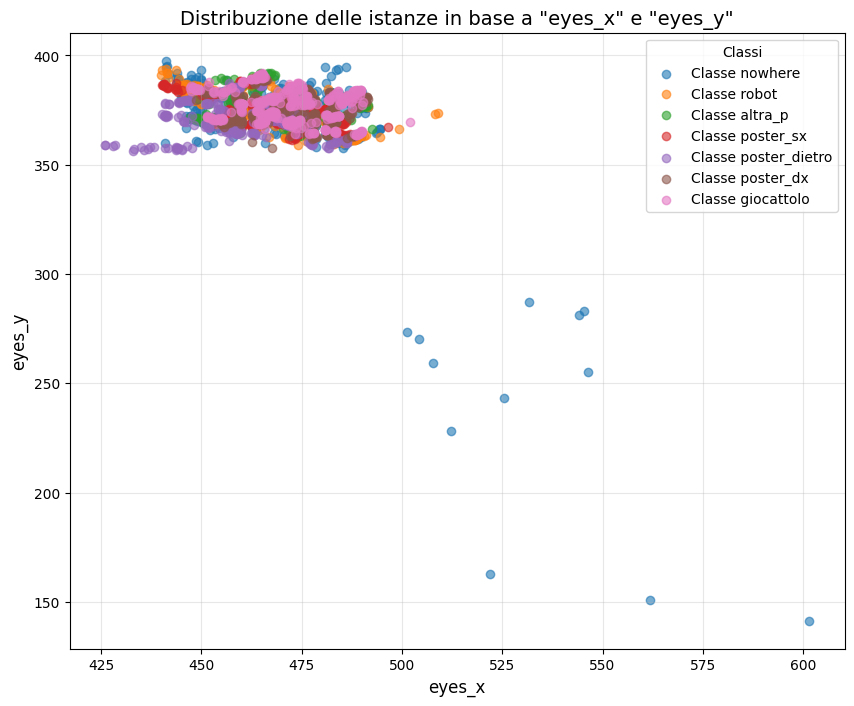

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

for class_label in y_train['label'].unique():
    class_data = X_train[y_train['label'] == class_label]
    plt.scatter(class_data['eyes_x'], class_data['eyes_y'], label=f'Classe {class_label}', alpha=0.6)
plt.title('Distribuzione delle istanze in base a "eyes_x" e "eyes_y"', fontsize=14)
plt.xlabel('eyes_x', fontsize=12)
plt.ylabel('eyes_y', fontsize=12)
plt.legend(title='Classi')
plt.grid(alpha=0.3)

plt.show()


In [ ]:
filtered_indices = X_train['eyes_y'] >= 300

X_train = X_train[filtered_indices]
y_train = y_train.loc[filtered_indices]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (4445, 7)
y_train shape: (4445, 1)


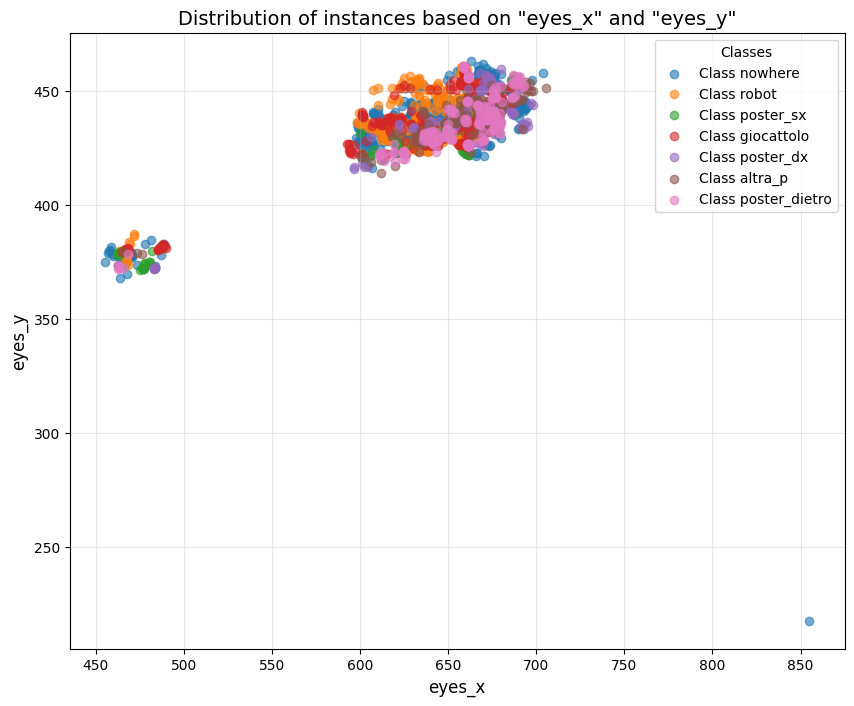

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Create the scatter plot with a different color for each class
for class_label in y_therapists['label'].unique():
    class_data = X_therapists[y_therapists['label'] == class_label]
    plt.scatter(class_data['eyes_x'], class_data['eyes_y'], label=f'Class {class_label}', alpha=0.6)

# Add labels and title in English
plt.title('Distribution of instances based on "eyes_x" and "eyes_y"', fontsize=14)
plt.xlabel('eyes_x', fontsize=12)
plt.ylabel('eyes_y', fontsize=12)
plt.legend(title='Classes')
plt.grid(alpha=0.3)

# Show the plot
plt.show()

In [ ]:
# Filtra X_train mantenendo solo le righe in cui 'eyes_y' >= 300
filtered_indices = (X_therapists['eyes_y'] >= 400) & (X_therapists['eyes_x'] >= 550)

# Applica il filtro a X_train e y_train in modo coerente
X_therapists = X_therapists[filtered_indices]
y_therapists = y_therapists.loc[filtered_indices]

# Stampa le nuove dimensioni
print(f"X_train shape: {X_therapists.shape}")
print(f"y_train shape: {y_therapists.shape}")


X_train shape: (2755, 7)
y_train shape: (2755, 1)


###Dataset creation

In [ ]:


X_train_new = pd.concat([X_train, X_therapists], axis = 0)
y_train_new = pd.concat([y_train, y_therapists], axis = 0)


y_train_new = pd.concat([y_train_new, y_test[X_test['patient'].isin(['DG16-T0', 'DG15-T0', 'DG03-T0', 'DG07-T0', 'DG11-T0'])]], axis = 0)
X_train_new = pd.concat([X_train_new, X_test[X_test['patient'].isin(['DG16-T0', 'DG15-T0', 'DG03-T0', 'DG07-T0', 'DG11-T0'])]], axis = 0)

X_test_new = X_train[X_train['patient'].isin(['CaLa_CH', 'DaSi_CH', 'MaFa_CH', 'MaZe_CH', 'MaZa_CH','FaMa_CH', 'DuBo_CH'])]
y_test_new = y_train[X_train['patient'].isin(['CaLa_CH', 'DaSi_CH', 'MaFa_CH', 'MaZe_CH', 'MaZa_CH','FaMa_CH', 'DuBo_CH'])]

y_val_new = pd.concat([y_val, y_therapists_val], axis = 0)
X_val_new= pd.concat([X_val, X_therapists_val], axis = 0)

print(X_train_new['patient'].unique())
#print(X_test_new['patient'].unique())
print(X_val_new['patient'].unique())
X_train = X_train_new
y_train = y_train_new
X_test = X_test_new
y_test = y_test_new
X_val = X_val_new
y_val = y_val_new

['LaCa_CH' 'ZeMa_CH' 'ZaDe_CH' 'ZaMa_CH' 'SiDa_CH' 'PrMu_CH' 'MuPr_CH'
 'CaLa_CH' 'DaSi_CH' 'MaFa_CH' 'MaZe_CH' 'MaZa_CH' 'FaMa_CH' 'DuBo_CH'
 'LaCa_TH' 'ZeMa_TH' 'SiDa_TH' 'PrMu_TH' 'MuPr_TH' 'CaLa_TH' 'DaSi_TH'
 'MaFa_TH' 'MaZe_TH' 'MaZa_TH' 'FaMa_TH' 'DuBo_TH' 'DeZa_TH']
['DeZa_CH' 'BoDu_CH' 'AnSo_CH' 'BoDu_TH' 'AnSo_TH']


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
X_train_encoded = label_encoder.fit_transform(X_train['use_robot'])
robot_dict = {index: rob for index, rob in enumerate(label_encoder.classes_)}

X_val_encoded = label_encoder.fit_transform(X_val['use_robot'])
X_test_encoded = label_encoder.fit_transform(X_test['use_robot'])
#X_therapists_encoded = label_encoder.fit_transform(X_therapists['use_robot'])

# Aggiungi le etichette numeriche al DataFrame

X_train['use_robot'] = X_train_encoded
X_val['use_robot'] = X_val_encoded
X_test['use_robot'] = X_test_encoded
#X_therapists['use_robot'] = X_therapists_encoded

# Visualizza il dizionario e i dati
print("Dizionario delle etichette:\n", robot_dict)

Dizionario delle etichette:
 {0: 'R', 1: 'WR'}


In [ ]:
X_test=X_test.drop(columns=['patient'])
X_train=X_train.drop(columns=['patient'])
X_val=X_val.drop(columns=['patient'])


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Mappiamo le etichette (y) in numeri
label_encoder = LabelEncoder()
y_enc_train = label_encoder.fit_transform(y_train)
label_dict = {index: label for index, label in enumerate(label_encoder.classes_)}

y_enc_val = label_encoder.fit_transform(y_val)
y_enc_test = label_encoder.fit_transform(y_test)


# Aggiungi le etichette numeriche al DataFrame
y_train['label_encoded'] = y_enc_train
y_val['label_encoded'] = y_enc_val
y_test['label_encoded'] = y_enc_test

y_train=y_train.drop(columns=['label'])
y_val=y_val.drop(columns=['label'])
y_test=y_test.drop(columns=['label'])

# Visualizza il dizionario e i dati
print("Dizionario delle etichette:\n", label_dict)


Dizionario delle etichette:
 {0: 'altra_p', 1: 'giocattolo', 2: 'nowhere', 3: 'poster_dietro', 4: 'poster_dx', 5: 'poster_sx', 6: 'robot'}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


##Downsampling

Based on confidence

In [ ]:
import numpy as np
import pandas as pd

# Step 1: Creazione di un DataFrame per lavorare più facilmente con i dati
data = pd.DataFrame(X_train)
data['label_encoded'] = y_train
data['confidence_azimuth'] = data['confidence_azimuth']  # Assicuriamoci che questa colonna esista

# Step 2: Conta il numero di istanze per ciascuna classe
class_counts = data['label_encoded'].value_counts()
min_class_count = class_counts.min()

# Step 3: Bilanciamento delle classi
balanced_data = []

for cls in class_counts.index:
    class_data = data[data['label_encoded'] == cls]
    if class_counts[cls] > min_class_count:
        # Ordiniamo per 'confidence_azimuth' crescente
        class_data = class_data.sort_values(by='confidence_azimuth', ascending=True)
        # Manteniamo solo le prime 'min_class_count' istanze
        class_data = class_data.iloc[:min_class_count]
    balanced_data.append(class_data)

# Concatenazione dei dati bilanciati
balanced_data = pd.concat(balanced_data)

# Step 4: Separazione delle feature e delle etichette
X_train_balanced = balanced_data.drop(columns=['label_encoded'])
y_train_balanced = balanced_data['label_encoded']

print(f"Dimensioni originali: {X_train.shape}, {y_train.shape}")
print(f"Dimensioni bilanciate: {X_train_balanced.shape}, {y_train_balanced.shape}")


Dimensioni originali: (7200, 6), (7200, 1)
Dimensioni bilanciate: (3241, 6), (3241,)


<ipython-input-28-07923991113f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_train_balanced, palette='viridis')
<ipython-input-28-07923991113f>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


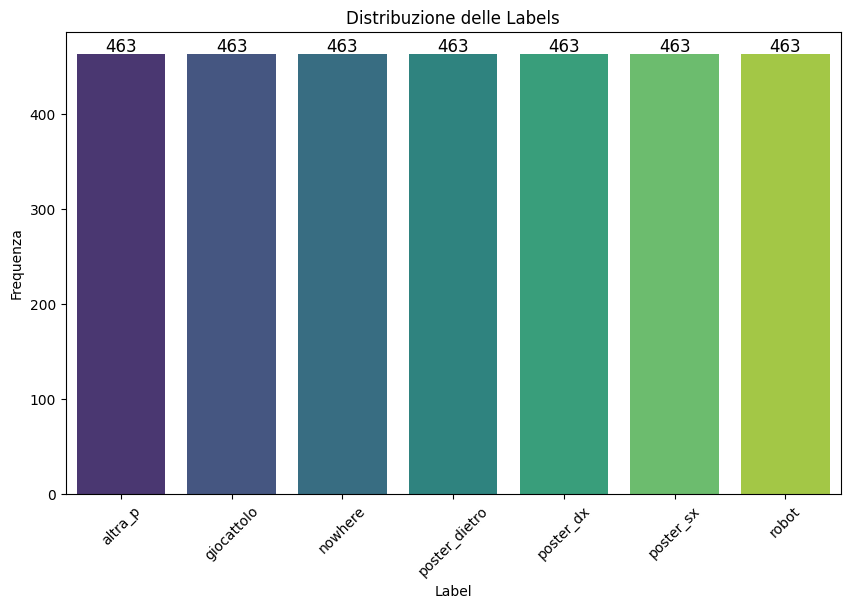

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crea la figura
plt.figure(figsize=(10, 6))

# Countplot con le etichette numeriche
ax = sns.countplot(x=y_train_balanced, palette='viridis')

# Aggiungi il conteggio sopra ogni barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

# Aggiungi le etichette originali (dall'indice numerico)
labels = [label_dict[i] for i in ax.get_xticks()]  # Mappa gli indici numerici alle etichette
ax.set_xticklabels(labels)

# Titoli e etichette
plt.title('Distribuzione delle Labels')
plt.xlabel('Label')
plt.ylabel('Frequenza')
plt.xticks(rotation=45)
plt.show()


##Upsampling

<ipython-input-75-db617beb97aa>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_train['label_encoded'], palette='viridis')
<ipython-input-75-db617beb97aa>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


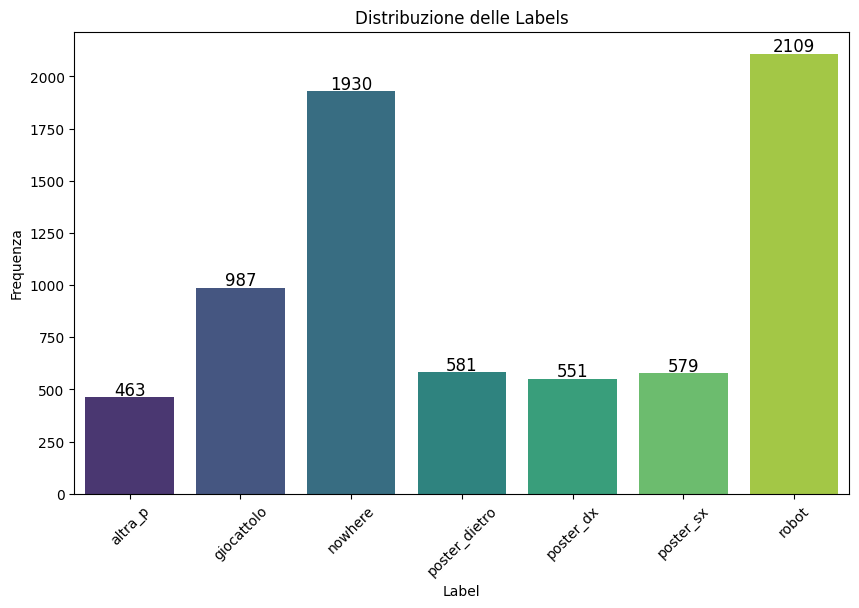

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crea la figura
plt.figure(figsize=(10, 6))

# Countplot con le etichette numeriche
ax = sns.countplot(x=y_train['label_encoded'], palette='viridis')

# Aggiungi il conteggio sopra ogni barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

# Aggiungi le etichette originali (dall'indice numerico)
labels = [label_dict[i] for i in ax.get_xticks()]  # Mappa gli indici numerici alle etichette
ax.set_xticklabels(labels)

# Titoli e etichette
plt.title('Distribuzione delle Labels')
plt.xlabel('Label')
plt.ylabel('Frequenza')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from imblearn.over_sampling import SMOTE

# Create a SMOTE object with desired parameters
smote = SMOTE(sampling_strategy={0: 2109, 1: 2109, 3: 2109, 4:2109, 5:2109}, random_state=42)

# Fit and apply SMOTE to your data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train['label_encoded'])
# Convert the resampled target variable back to a DataFrame
y_train_resampled = pd.DataFrame({'label_encoded': y_train_resampled})

# Now X_train_resampled and y_train_resampled contain the upsampled data
print(f"Dimensioni dopo upsampling: {X_train_resampled.shape}, {y_train_resampled.shape}")



Dimensioni dopo upsampling: (14584, 6), (14584, 1)


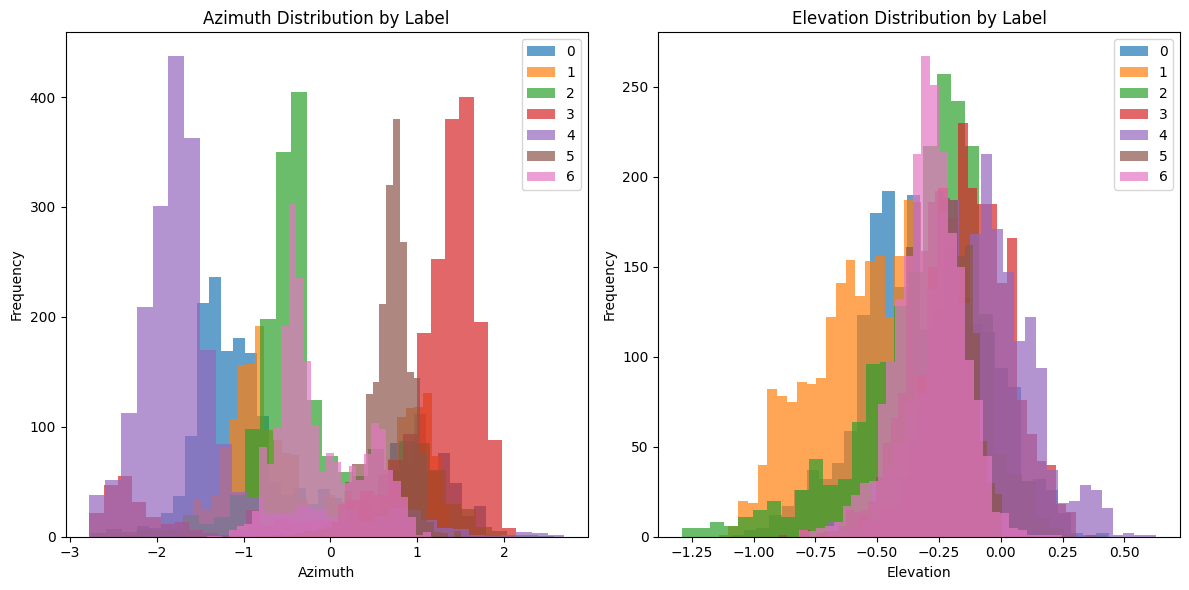

In [ ]:
import matplotlib.pyplot as plt

# Assuming X_train and y_train are defined as in your provided code

plt.figure(figsize=(12, 6))

# Azimuth Histogram
plt.subplot(1, 2, 1)
# Ensure both X_train_resampled and y_train_resampled have the same number of samples
X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X_train.columns) # Convert X_train_resampled to DataFrame
for label in np.unique(y_train_resampled['label_encoded']):
    plt.hist(X_train_resampled_df[y_train_resampled['label_encoded'] == label]['azimuth'], bins=30, alpha=0.7, label=str(label))
plt.xlabel('Azimuth')
plt.ylabel('Frequency')
plt.title('Azimuth Distribution by Label')
plt.legend()


# Elevation Histogram
plt.subplot(1, 2, 2)
for label in np.unique(y_train_resampled['label_encoded']):
    plt.hist(X_train_resampled_df[y_train_resampled['label_encoded'] == label]['elevation'], bins=30, alpha=0.7, label=str(label))
plt.xlabel('Elevation')
plt.ylabel('Frequency')
plt.title('Elevation Distribution by Label')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Find indices where y_train['label_encoded'] == 2
indices_to_remove = y_train_resampled[y_train_resampled['label_encoded'] == 2].index

# Remove the first 200 such indices (or fewer if there are not 200)
num_to_remove = min(300, len(indices_to_remove))
indices_to_remove = indices_to_remove[:num_to_remove]

# Remove the corresponding rows from X_train and y_train
X_train_resampled= X_train_resampled.drop(indices_to_remove)
y_train_resampled = y_train_resampled.drop(indices_to_remove)

print(f"Dimensioni dopo rimozione: {X_train.shape}, {y_train.shape}")

Dimensioni dopo rimozione: (7200, 6), (7200, 1)


Dimensioni dopo l'aumento dei dati: (14763, 6), (14763, 1)


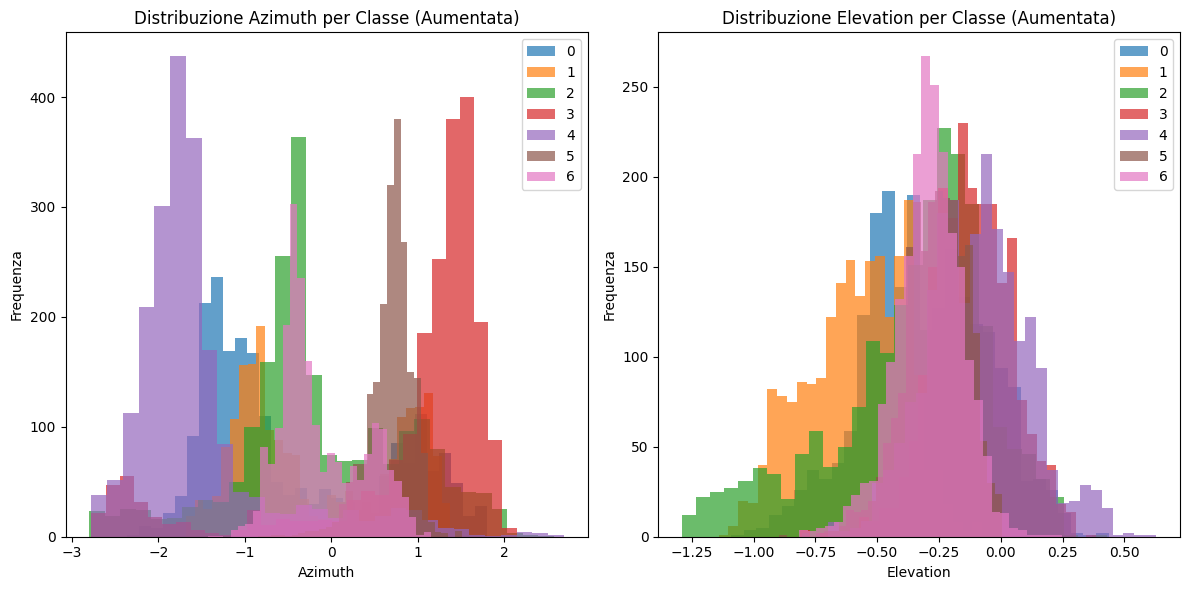

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# Filtra i dati per la classe 2
class_2_data = X_train_resampled[y_train_resampled['label_encoded'] == 2]

# Calcola media e deviazione standard per azimuth ed elevation della classe 2
mean_azimuth = class_2_data['azimuth'].mean()
std_azimuth = class_2_data['azimuth'].std()

mean_elevation = class_2_data['elevation'].mean()
std_elevation = class_2_data['elevation'].std()

# Definisci il numero di campioni da generare (1000 - numero campioni attuali della classe 2)
n_samples_to_generate = 2109 - len(class_2_data)

# Genera nuovi valori per azimuth ed elevation lontani dalla distribuzione attuale
# Usiamo una distribuzione uniforme che esclude la zona intorno alla media e alla deviazione standard

# Imposta il range per evitare la zona ad alta densità
azimuth_range = (-0.2, -0.2)  # 2 std fuori dalla media
elevation_range = (0,0)

# Genera nuovi azimuth e elevation lontani dalla distribuzione attuale
new_azimuth = np.random.uniform(low=-2.8, high=2, size=n_samples_to_generate)
new_elevation = np.random.uniform(low=-1.25, high=0.25, size=n_samples_to_generate)

# Filtra i nuovi valori che rientrano nel range escluso (ad alta densità)
while any((new_azimuth >= azimuth_range[0]) & (new_azimuth <= azimuth_range[1])) or any((new_elevation >= elevation_range[0]) & (new_elevation <= elevation_range[1])):
    new_azimuth = np.random.uniform(low=-2.8, high=2, size=n_samples_to_generate)
    new_elevation = np.random.uniform(low=-1.25, high=0.25, size=n_samples_to_generate)

# Creiamo un DataFrame con i nuovi campioni
new_samples = pd.DataFrame({
    'azimuth': new_azimuth,
    'elevation': new_elevation
})

# Riempimento degli altri attributi con la media dei valori esistenti nella classe 2
for col in X_train.columns:
    if col not in ['azimuth', 'elevation']:
        new_samples[col] = class_2_data[col].mean()

# Creiamo i valori corrispondenti per y_train (classe 2)
new_y_train = pd.DataFrame({'label_encoded': [2] * n_samples_to_generate})

# Concatenazione dei nuovi campioni con il dataset originale
X_train_augmented = pd.concat([X_train_resampled, new_samples], ignore_index=True)
y_train_augmented = pd.concat([y_train_resampled, new_y_train], ignore_index=True)

# Verifica delle dimensioni finali
print(f"Dimensioni dopo l'aumento dei dati: {X_train_augmented.shape}, {y_train_augmented.shape}")

# Verifica della distribuzione del dataset aumentato
plt.figure(figsize=(12, 6))

# Istogramma per l'azimuth
plt.subplot(1, 2, 1)
for label in np.unique(y_train_augmented['label_encoded']):
    plt.hist(X_train_augmented[y_train_augmented['label_encoded'] == label]['azimuth'], bins=30, alpha=0.7, label=str(label))
plt.xlabel('Azimuth')
plt.ylabel('Frequenza')
plt.title('Distribuzione Azimuth per Classe (Aumentata)')
plt.legend()

# Istogramma per l'elevation
plt.subplot(1, 2, 2)
for label in np.unique(y_train_augmented['label_encoded']):
    plt.hist(X_train_augmented[y_train_augmented['label_encoded'] == label]['elevation'], bins=30, alpha=0.7, label=str(label))
plt.xlabel('Elevation')
plt.ylabel('Frequenza')
plt.title('Distribuzione Elevation per Classe (Aumentata)')
plt.legend()

plt.tight_layout()
plt.show()


<ipython-input-81-f38c36594bf4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_train_augmented['label_encoded'], palette='viridis')
<ipython-input-81-f38c36594bf4>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


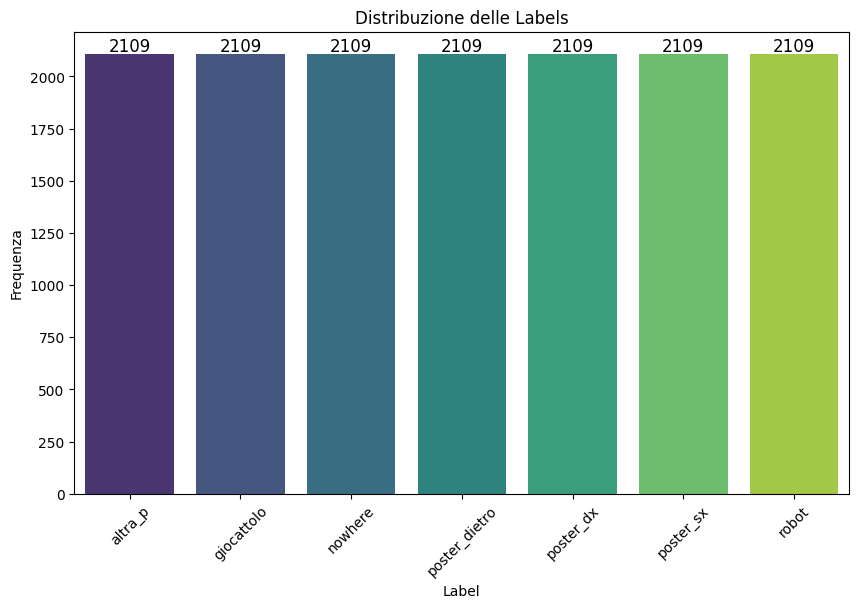

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))


ax = sns.countplot(x=y_train_augmented['label_encoded'], palette='viridis')

# Aggiungi il conteggio sopra ogni barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')

# Aggiungi le etichette originali (dall'indice numerico)
labels = [label_dict[i] for i in ax.get_xticks()]  # Mappa gli indici numerici alle etichette
ax.set_xticklabels(labels)

# Titoli e etichette
plt.title('Distribuzione delle Labels')
plt.xlabel('Label')
plt.ylabel('Frequenza')
plt.xticks(rotation=45)
plt.show()


## Norm + dataloader

In [ ]:

class_counts = np.bincount(y_train_augmented['label_encoded'])
total_samples = class_counts.sum()


relative_frequency = class_counts / total_samples
inverse_frequency = 1.0 / relative_frequency

smoothing_factor = 0.5
alpha = (inverse_frequency + smoothing_factor) / (inverse_frequency + smoothing_factor).sum()
alpha

array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
       0.14285714, 0.14285714])

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import numpy as np

scaler = StandardScaler()

## Calcolo di min e max per ogni feature
# scaler.fit(filtered_data)
# X_train_scaled = scaler.transform(filtered_data)
scaler.fit(X_train_augmented)
X_train_scaled = scaler.transform(X_train_augmented)

print("Minimo di ciascuna colonna:", np.min(X_train_scaled, axis=0))

# Stampa il massimo di ciascuna colonna
print("Massimo di ciascuna colonna:", np.max(X_train_scaled, axis=0))

scaler.fit(X_val)
X_val_scaled = scaler.transform(X_val)

print("Minimo di ciascuna colonna:", np.min(X_val_scaled, axis=0))

# Stampa il massimo di ciascuna colonna
print("Massimo di ciascuna colonna:", np.max(X_val_scaled, axis=0))

scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

print("Minimo di ciascuna colonna:", np.min(X_test_scaled, axis=0))

# Stampa il massimo di ciascuna colonna
print("Massimo di ciascuna colonna:", np.max(X_test_scaled, axis=0))




# Normalizza i dati di input (X)
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.fit_transform(X_val)
# X_test_scaled = scaler.fit_transform(X_test)

# Inizializza OneHotEncoder per fare l'encoding delle etichette
encoder = OneHotEncoder(sparse_output=False)

# Esegui l'encoding one-hot per le etichette
'''y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))'''

# Converti in DataFrame
X_train_df = pd.DataFrame(X_train_scaled, columns=[f'feature_{i+1}' for i in range(X_train_scaled.shape[1])])
X_val_df = pd.DataFrame(X_val_scaled, columns=[f'feature_{i+1}' for i in range(X_val_scaled.shape[1])])
X_test_df = pd.DataFrame(X_test_scaled, columns=[f'feature_{i+1}' for i in range(X_test_scaled.shape[1])])

'''y_train_df = pd.DataFrame(y_train_encoded, columns=[f'class_{i}' for i in range(y_train_encoded.shape[1])])
y_val_df = pd.DataFrame(y_val_encoded, columns=[f'class_{i}' for i in range(y_val_encoded.shape[1])])
y_test_df = pd.DataFrame(y_test_encoded, columns=[f'class_{i}' for i in range(y_test_encoded.shape[1])])'''

# Verifica le dimensioni dei dati trasformati
print(f"Dimensione Train dopo la normalizzazione: {X_train_df.shape}")
print(f"Dimensione Validation dopo la normalizzazione: {X_val_df.shape}")
print(f"Dimensione Test dopo la normalizzazione: {X_test_df.shape}")


Minimo di ciascuna colonna: [-0.65123933 -2.36629584 -3.88722669 -1.2307345  -1.3854378  -0.79087832]
Massimo di ciascuna colonna: [10.48229495  2.49044949  3.56400614  1.83096238  2.06875214  1.30729211]
Minimo di ciascuna colonna: [-0.45495958 -2.71183341 -3.95660225 -0.6843925  -1.47063352 -0.64868005]
Massimo di ciascuna colonna: [10.27684345  2.97443778  2.98646701  4.35743477  4.35609293  1.54159204]
Minimo di ciascuna colonna: [-0.69882037 -2.3413539  -2.67759746 -3.7579531  -7.27925411 -0.73602465]
Massimo di ciascuna colonna: [5.78959619 3.74952284 2.48928954 5.11159177 6.33346905 1.35865015]
Dimensione Train dopo la normalizzazione: (14763, 6)
Dimensione Validation dopo la normalizzazione: (1121, 6)
Dimensione Test dopo la normalizzazione: (1958, 6)


In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np

# Definisci il Dataset personalizzato
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y.values.astype(np.int64)  # Convert y to NumPy array

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X.iloc[idx].astype(np.float32).values, dtype=torch.float32)
        # If self.y[idx] is a scalar, directly convert it to a tensor
        y = torch.tensor(self.y[idx], dtype=torch.long) if np.isscalar(self.y[idx]) else torch.tensor(self.y[idx][0], dtype=torch.long)
        return x, y

# Crea i dataset personalizzati per train, validation e test
train_dataset = CustomDataset(X_train_df, y_train_augmented)
validation_dataset = CustomDataset(X_val_df, y_val)
test_dataset = CustomDataset(X_test_df, y_test)

# Crea i DataLoader
data_loader = {
    'train': DataLoader(train_dataset, batch_size=20, shuffle=True),
    'pretrain': DataLoader(train_dataset, batch_size=20, shuffle=True),
    'test': DataLoader(test_dataset, batch_size=1),
    'pretest': DataLoader(test_dataset, batch_size=1),
    'val': DataLoader(validation_dataset, batch_size=1),
}

# Stampa le dimensioni del DataLoader per verificare
print("Numero di esempi nel train dataset:", len(train_dataset))
print("Numero di esempi nel validation dataset:", len(validation_dataset))
print("Numero di esempi nel test dataset:", len(test_dataset))

Numero di esempi nel train dataset: 14763
Numero di esempi nel validation dataset: 1121
Numero di esempi nel test dataset: 1958


In [ ]:
mean = torch.tensor(X_train_df.mean(axis=0).values, dtype=torch.float32)
std = torch.tensor(X_train_df.std(axis=0).values, dtype=torch.float32)
print(std)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [ ]:


def plot(epochs, plottable, ylabel='', name=''):
    plt.clf()
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.plot(epochs, plottable)
    plt.savefig('{}.pdf'.format(name), bbox_inches='tight')

def fix_all_seeds(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

def configure_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

def configure_device(gpu_id):
    if gpu_id is not None:
        torch.cuda.set_device(gpu_id)

def model_mlp_run(data_loader, log_writer, opt, paths, model_name):

    # define the model
    # n_features = 24
    # n_state = 3
    # n_hidden_size_dec = 10
    # n_features_shape = N_FEATURES
    model = MLP(mean, std)
    #model = model.to(opt.gpu_id)
    # Define the loss function and optimizer

    #model = model.to(opt.gpu_id)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=opt.learning_rate, weight_decay=opt.l2_decay)

    # Pre-Training embeddings
    misclassified = train(model, optimizer, data_loader['train'], data_loader['val'], data_loader['test'],opt, log_writer['train'], log_writer['val'], model_name)

    #Saving

    directory = os.path.dirname(paths['checkpoint_mlp'])
    if not os.path.exists(directory):
        os.makedirs(directory)

    torch.save(model.state_dict(), paths['checkpoint_mlp'])

    #Loading
    model.load_state_dict(torch.load(paths['checkpoint_mlp']))
    model.eval()

    return model, misclassified


def validation_metric(y, y_pred):
    y = y.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()

    # import pdb; pdb.set_trace()
    # acc = np.mean((y[0] == y_pred).all())
    acc = accuracy_score(y, y_pred)
    f1_weight = f1_score(y, y_pred, average='weighted')
    f1_macro = f1_score(y, y_pred, average='macro')
    f1_micro = f1_score(y, y_pred, average='micro')
    return acc, f1_micro


def precision_metric(y_pred, y, gaze, model):
    count = 0
    y_pred = torch.cat(y_pred)
    # y_pred = torch.reshape(y_pred, (-1,7))
    y = torch.cat(y)
    y = y.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()
    # yarg = np.argmax(y, axis = 1)
    # ypredarg = np.argmax(y_pred, axis = 1)
    gaze = torch.cat(gaze)
    gaze = torch.reshape(gaze, (-1,6))
    misclass = []
    for i in range(0, len(y_pred)):
      if(y_pred[i] == 6 and y[i] == 2):
        x = gaze[i]# Esempio di input
        x = x.cpu().detach().numpy()
        tensor = torch.tensor(x)
        tensor = tensor.float()
        tensor = tensor.unsqueeze(0)
        output, activations = model.forward(tensor)
        #print(f'Predizione fatta: {y_pred[i]}')
        #print(f'Output: {output}')
        #print(f'GT: {y[i]}')
        #print(f'Features: {gaze[i]}')
        misclass.append(i)

        #for j, activation in enumerate(activations):
          #print(f"Activation at layer {j+1}: {activation}")
    print(f'Numero di misclassification (pred = 6 vs true = 2) in video WR: {count}')

   # confmat = multilabel_confusion_matrix(y, y_pred, labels = [0,1,2,3,4,5,6])
    cm = confusion_matrix(y, y_pred, labels=[0, 1, 2, 3, 4, 5, 6])
    precision = precision_score(y, y_pred, average=None, labels=[0, 1, 2, 3, 4, 5, 6])
    recall = recall_score(y, y_pred, average=None, labels=[0, 1, 2, 3, 4, 5, 6])
    accuracy = accuracy_score(y, y_pred)
    f1_class = f1_score(y, y_pred, average=None, labels=[0, 1, 2, 3, 4, 5, 6])
    f1_micro = f1_score(y, y_pred, average='micro')



    print("\nPrecision per class:", precision)
    print("Recall per class:", recall)
    print("F1-score per class:", f1_class)
    print("F1 vecchia: ", f1_class.mean())
    print("F1 micro:",f1_micro)
    print("Overall Accuracy:", accuracy)


    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=[0, 1, 2, 3, 4, 5, 6], yticklabels=[0, 1, 2, 3, 4, 5, 6])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # import pdb; pdb.set_trace()
    # sumconf = np.sum(confmat, axis=0)

    # precision = sumconf[1,1]/(sumconf[0,1]+ sumconf[1,1])
    # accuracy = (sumconf[0,0]+sumconf[1,1])/(sumconf[0,0]+ sumconf[1,0]+sumconf[1,1]+sumconf[0,1])
    # import pdb; pdb.set_trace()

    return precision, accuracy, misclass

def train_batch(x, y, model, optimizer):
    model.train() #il modello entra in modalità training
    if optimizer is not None:
        optimizer.zero_grad() #resetta i gradienti

    loss = model.loss(x, y) #calcola la loss

    if optimizer is not None:
        loss.backward()
        optimizer.step()

    return loss.detach()

def validate_batch(x, y, model):
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        loss = model.loss(x, y)
    return loss


def train(model, optimizer, train_dataloader, dev_dataloader, test_dataloader, opt, train_writer, val_writer, model_name, requires_reset=False, viz = True):
    train_tot_losses = []
    val_mean_metrics = []
    val_tot_losses = []
    # Run the training loop
    for epoch in range(0, opt.epochs): # 5 epochs at maximum

        # Print epoch
        print(f'Starting epoch {epoch+1}')
        batch_train_losses = []
        train_accuracies = []
        train_f1s = []
        # Iterate over the DataLoader for training data
        for i, sample in enumerate(train_dataloader):
            model.train()
            gaze, output = sample

            #gaze, output = gaze.to(opt.gpu_id), output.to(opt.gpu_id)
            train_loss = train_batch(gaze, output, model,  optimizer)

            batch_train_losses.append(train_loss) ##loss per ogni batch dell'epoca

            y_pred = model.predict(gaze)
            train_acc, train_f1 = validation_metric(output, y_pred)  ## accuratezza della batch in validation
            train_accuracies.append(train_acc)
            train_f1s.append(train_f1)

        epoch_train_acc = torch.tensor(train_accuracies).mean().item()
        epoch_train_f1 = torch.tensor(train_f1s).mean().item()
        epoch_train_loss = torch.tensor(batch_train_losses).mean().item()  ## media sulle batch = loss dell'epoca
        print('Training loss: %.4f' % epoch_train_loss)
        print('Training accuracy: %.4f'%epoch_train_acc)
        print(f'\nTraining F1: {epoch_train_f1}\n')
        train_writer.add_scalar('loss', epoch_train_loss, global_step=opt.startiter + epoch)

        train_tot_losses.append(epoch_train_loss) ## lista di loss per ogni epoca

        ### VALIDATION SULL'EPOCA ###
        print(f'Validation epoch {epoch+1}')
        model.eval()
        val_metrics = []
        y_pred_all = []
        y_true_all = []
        batch_val_losses = []
        val_f1s = []

        for i, sample in enumerate(dev_dataloader):
          gaze, output = sample
          loss_val = validate_batch(gaze, output, model)
          batch_val_losses.append(loss_val)

          y_pred = model.predict(gaze)
          val_metric, val_f1 = validation_metric(output, y_pred)  ## accuratezza della batch in validation

          y_pred_all.append(y_pred)
          y_true_all.append(output)
          val_metrics.append(val_metric)
          val_f1s.append(val_f1)

        epoch_f1_val = torch.tensor(val_f1s).mean().item()
        print(f'\nValidation F1: {epoch_f1_val}\n')
        epoch_metric_val = torch.tensor(val_metrics).mean().item() ## accuratezza media dell'epoca
        epoch_loss_val = torch.tensor(batch_val_losses).mean().item()  ## validation loss sull'epoca
        print(f'Validation loss: {epoch_loss_val}')
        print(f'Validation accuracy: {epoch_metric_val}')
        val_tot_losses.append(epoch_loss_val)


    str_epochs = [str(i) for i in range(0, opt.epochs )]

    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.xlabel('Epoch')
    plt.title('Losses')
    plt.plot(str_epochs, train_tot_losses, label='Training Loss')  # Plot training losses
    plt.plot(str_epochs, val_tot_losses, label='Validation Loss')  # Plot validation losses
    plt.legend()
    plt.grid(True)
    plt.show()

    # Process is complete.
    print('Training process has finished.')
### TEST ####

    model.eval() #passa in modalità di valutazione
    test_accuracies = []
    y_pred_all = []
    y_true_all = []
    gaze_all = []
    for i, sample in enumerate(test_dataloader):
        gaze, output = sample
        # gaze, output = gaze.to(opt.gpu_id, output.to(opt.gpu_id))
        y_pred_test = model.predict(gaze)

        test_acc = validation_metric(output, y_pred_test)

        gaze_all.append(gaze)
        y_pred_all.append(y_pred_test)
        y_true_all.append(output)
        test_accuracies.append(test_acc)


    tot_test_acc = torch.tensor(test_accuracies).mean().item() ## accuratezza totale sul test

    # import pdb; pdb.set_trace()
    precision, accuracy, misclassified = precision_metric(y_pred_all,y_true_all, gaze_all, model)
    #print(misclassified)
    print('Precision', precision)
    print('Accuracy', accuracy)
    print('Accuracy barbara:', tot_test_acc)
    return misclassified




##training

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('-data', default='data.pkl',
                    help="Path to dataset.")
parser.add_argument('-epochs', type=int, default=30)
parser.add_argument('-learning_rate', type=float, default=.001)
parser.add_argument('-l2_decay', type=float, default=0.)
parser.add_argument('-batch_size', type=int, default=20)
parser.add_argument('-gpu_id', type=int, default=0)
parser.add_argument('-seed', type=int, default=0)
parser.add_argument('-model', type=str, default='baseline_memory')

opt = parser.parse_args(args=[])
sonpath='/content/drive/MyDrive/Progetto_Neuro/Modello/Weights'

checkpoint_path = os.path.join(sonpath, 'weights', 'checkpoint' + str(3) + '.pt')
checkpoint_cnn = os.path.join(sonpath, 'weights', 'checkpoint' + str(3) + '_cnn.pt')
checkpoint_path_final = os.path.join(sonpath, 'weights', 'checkpoint' + str(3) + '_final.pt')

configure_seed(opt.seed)
#configure_device(opt.gpu_id)

print("Fixing seed at "+ str(opt.seed))
fix_all_seeds(opt.seed)

paths= {
    'checkpoint_mlp': checkpoint_path,
    'checkpoint_cnn': checkpoint_cnn,
    'checkpoint_full': checkpoint_path_final
}

Fixing seed at 0


In [ ]:
# Verifica la forma di un batch del DataLoader di addestramento
for x_batch, y_batch in data_loader['train']:
    print("Shape di x_batch:", x_batch.shape)  # dovrebbe essere (batch_size, numero_di_caratteristiche)
    print("Shape di y_batch:", y_batch.shape)  # dovrebbe essere (batch_size,)
    break  # Usa break per esaminare solo il primo batch


Shape di x_batch: torch.Size([20, 6])
Shape di y_batch: torch.Size([20])


Starting epoch 1
Training loss: 1.7612
Training accuracy: 0.4046

Training F1: 0.4046459179070816

Validation epoch 1

Validation F1: 0.5414808206958073

Validation loss: 1.6211107969284058
Validation accuracy: 0.5414808392524719
Starting epoch 2
Training loss: 1.6625
Training accuracy: 0.5032

Training F1: 0.5031574199368517

Validation epoch 2

Validation F1: 0.5753791257805531

Validation loss: 1.5934826135635376
Validation accuracy: 0.5753791332244873
Starting epoch 3
Training loss: 1.6476
Training accuracy: 0.5168

Training F1: 0.5168470906630581

Validation epoch 3

Validation F1: 0.5887600356824264

Validation loss: 1.5759950876235962
Validation accuracy: 0.5887600183486938
Starting epoch 4
Training loss: 1.6361
Training accuracy: 0.5305

Training F1: 0.530469102390618

Validation epoch 4

Validation F1: 0.5994647636039251

Validation loss: 1.561721682548523
Validation accuracy: 0.5994647741317749
Starting epoch 5
Training loss: 1.6302
Training accuracy: 0.5347

Training F1: 0.5

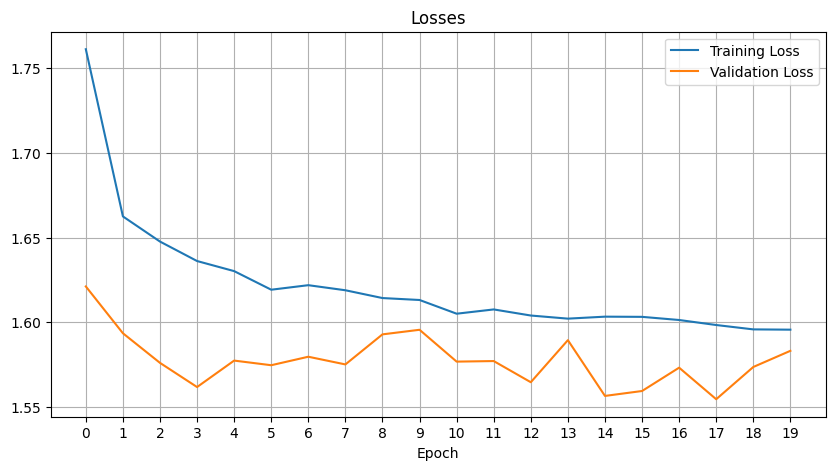

Training process has finished.
Numero di misclassification (pred = 6 vs true = 2) in video WR: 0

Precision per class: [0.18721461 0.71352785 0.28421053 0.03773585 0.05521472 0.00694444
 0.67179487]
Recall per class: [0.24260355 0.40881459 0.07012987 0.25806452 0.64285714 0.125
 0.57879234]
F1-score per class: [0.21134021 0.51980676 0.1125     0.06584362 0.10169492 0.01315789
 0.62183544]
F1 vecchia:  0.23516840627126032
F1 micro: 0.38661899897854957
Overall Accuracy: 0.38661899897854957


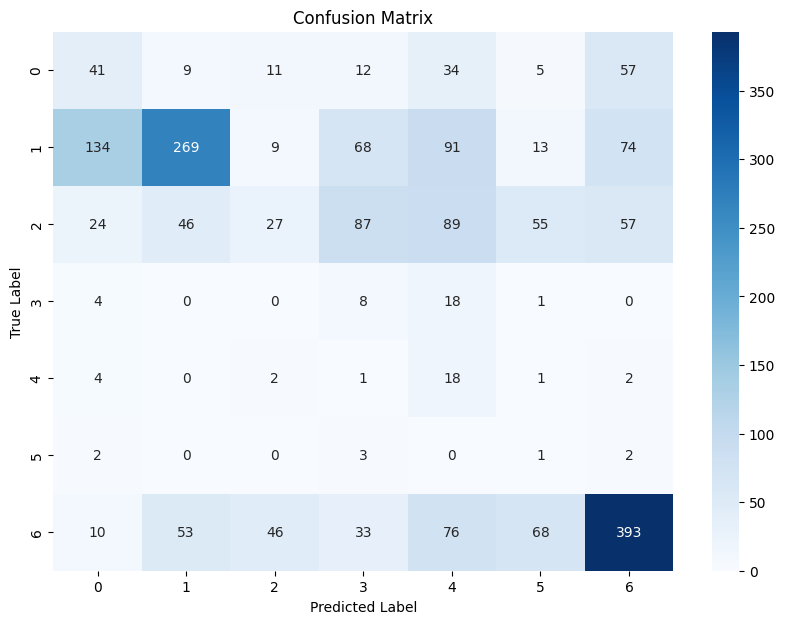

Precision [0.18721461 0.71352785 0.28421053 0.03773585 0.05521472 0.00694444
 0.67179487]
Accuracy 0.38661899897854957
Accuracy barbara: 0.38661899897854957
Running 


<ipython-input-88-6ae03410df5f>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(paths['checkpoint_mlp']))


In [ ]:

from datetime import datetime
now = datetime.now()
#
model_name = 'MLP'
log_writer = {
    'train': SummaryWriter(log_dir='./run_new/'+model_name+'/train/'+now.strftime("%Y-%m-%d-%H-%M-%S"), comment='train' + '_' + model_name),
    'test' : SummaryWriter(log_dir='./run_new/'+model_name+'/test/'+now.strftime("%Y-%m-%d-%H-%M-%S"), comment='test'+ '_' + model_name),
    'val': SummaryWriter(log_dir='./run_new/'+model_name+'/val/'+now.strftime("%Y-%m-%d-%H-%M-%S"), comment='val' + '_' + model_name),
}

if model_name == 'MLP':
    opt.startiter = 0
    opt.epochs = 20
    _, mis = model_mlp_run(data_loader,log_writer, opt, paths, model_name)
print("Running ")


In [ ]:
model = MLP(mean, std)
# Caricamento dello stato del modello
model.load_state_dict(torch.load(paths['checkpoint_mlp']))


# Definizione del percorso se non è già definito
checkpoint_path = '/content/drive/MyDrive/Progetto_Neuro/Modello/Weights/weights/checkpoint3.pt'
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

idx = 0
x=X_test_df.iloc[idx,:]# Esempio di input
x = x.to_numpy()

# Conversione da numpy array a PyTorch tensor
tensor = torch.tensor(x)
tensor = tensor.float()
tensor = tensor.unsqueeze(0)
output, activations = model.forward(tensor)
#print(y_train.iloc[idx])
#print(X_train_df.iloc[idx,:])


# Stampa delle attivazioni
for i, activation in enumerate(activations):
    print(f"Activation at layer {i+1}: {activation}")


Activation at layer 1: tensor([[-0.0992,  1.1034,  1.2950, -0.0479,  0.2658,  1.2173, -0.0489, -0.1237,
         -0.0910,  0.6673,  0.7844,  0.6445,  0.9736,  0.0999, -0.0355, -0.0596,
         -0.1214,  0.1013, -0.1135, -0.0740, -0.0611,  0.3317,  0.6598,  0.9187,
          1.4630,  0.6241,  1.1731,  0.5302,  0.4909,  0.8450, -0.1066, -0.0639]])
Activation at layer 2: tensor([[ 1.1008, -0.0645,  0.4890,  0.8257,  1.0792, -0.1771, -0.5349, -0.1928,
         -0.1217,  1.1222,  0.5387, -0.1263, -0.4109, -0.0996, -0.1986, -0.1382,
          1.5241,  1.8381,  2.1406, -0.1192, -0.1293, -0.0320,  0.5362, -0.0403,
         -0.2357, -0.5573, -0.1270, -0.2928, -0.0220, -0.2622, -0.0893, -0.3092,
          0.4981, -0.1029,  1.4186,  2.2135,  0.8570, -0.5724,  1.1547,  1.8526,
          2.0452,  0.7326, -0.4309,  2.3631, -0.2106,  0.2679, -0.1278, -0.0264,
         -0.0308, -0.0250, -0.1060, -0.1177,  1.4910,  1.6036, -0.1755,  2.0340,
         -0.0561,  0.9539, -0.0372,  1.5028,  0.1542,  1.0649

<ipython-input-92-7795efba83d7>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(paths['checkpoint_mlp']))
<ipython-input-92-7795efba83d7>:8

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


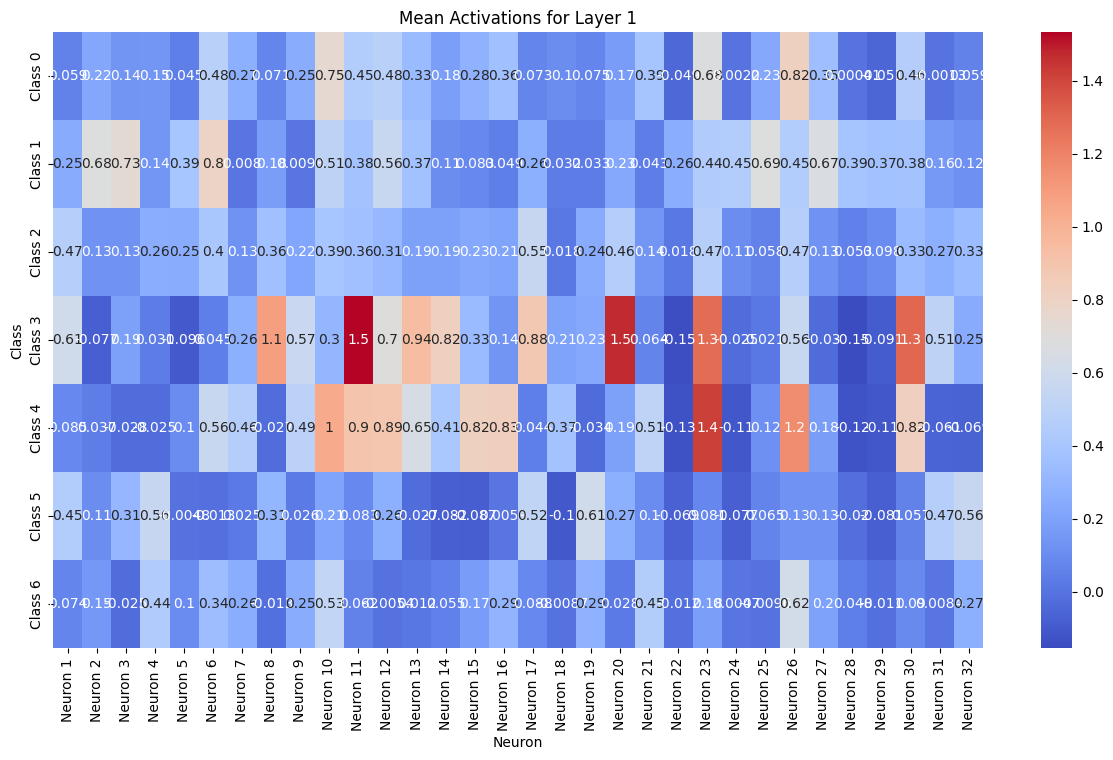

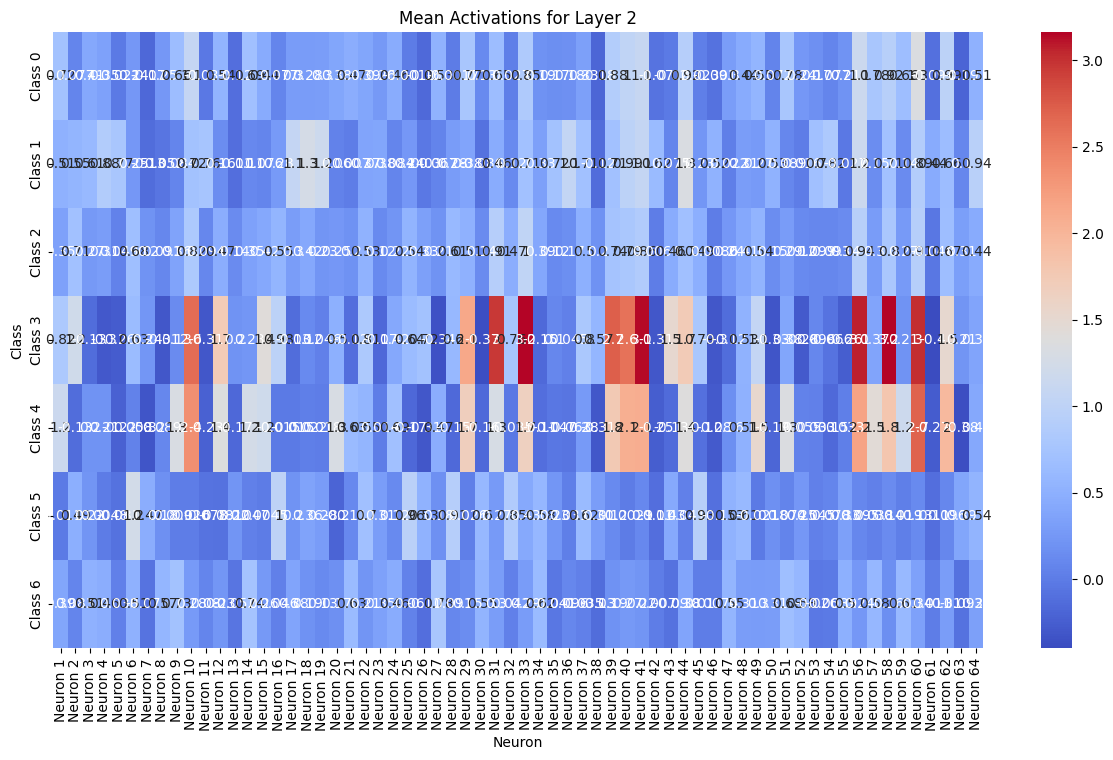

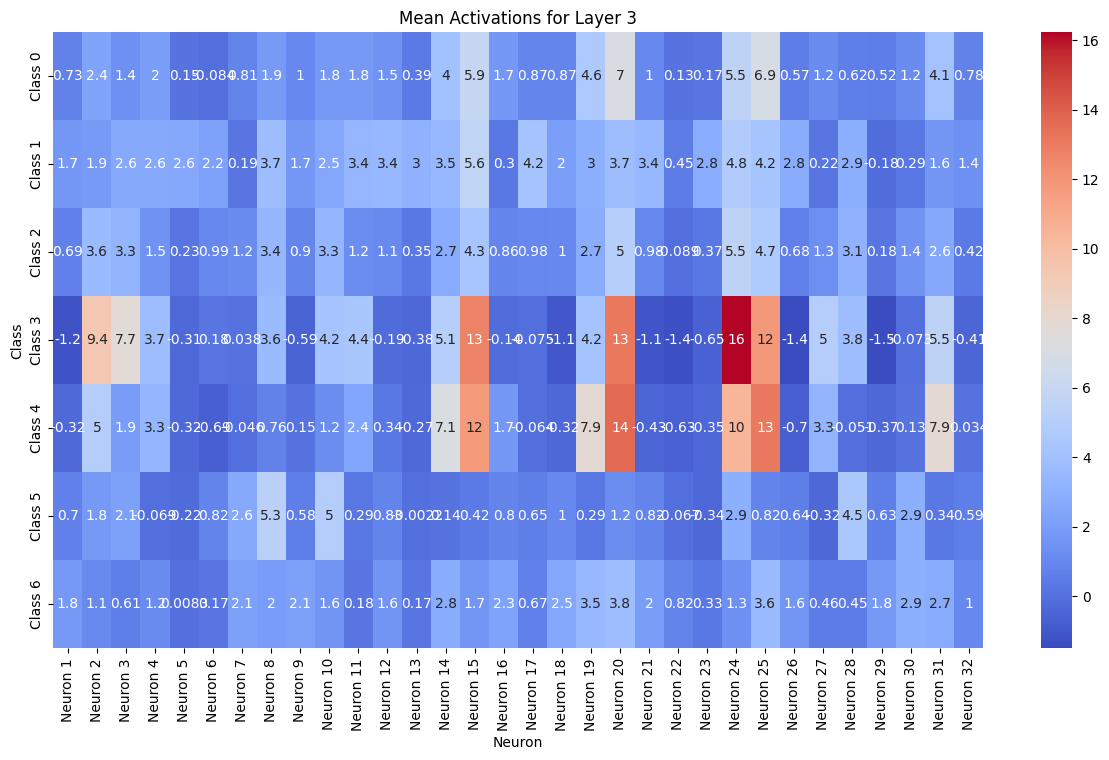

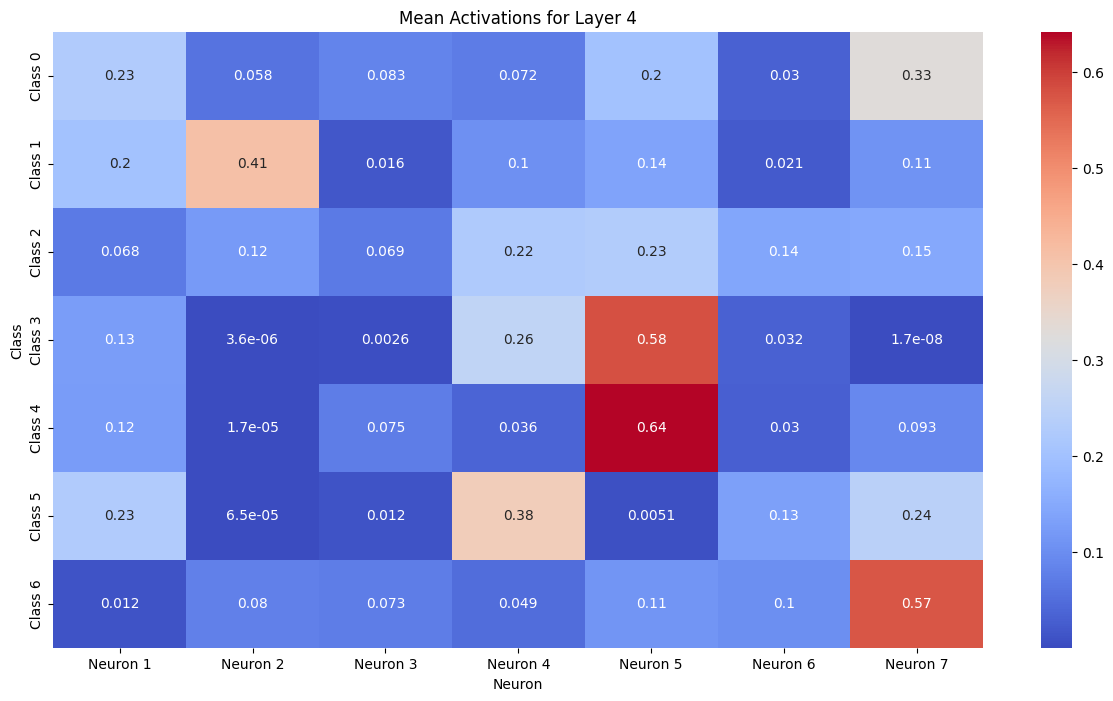

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# Funzione per calcolare le attivazioni medie per ogni neurone nei layer e per classe
def collect_average_activations_per_class(model, X_data, y_data):
    # Lista per raccogliere le attivazioni di ogni layer per ciascuna classe
    activations_per_class_layer = {cls: {i: [] for i in range(len(model.layers))} for cls in np.unique(y_data)}

    # Itera su tutti gli esempi del dataset
    for i in range(len(X_data)):
        x = X_data.iloc[i, :].to_numpy()  # Preleva un esempio di input
        tensor = torch.tensor(x).float()  # Convertilo in un tensore
        tensor = tensor.unsqueeze(0)  # Aggiungi dimensione batch
        label = y_data.iloc[i]['label_encoded']  # Etichetta della classe

        # Calcola le attivazioni per ogni layer
        output, activations = model.forward(tensor)

        # Salva le attivazioni per ogni layer e per classe
        for layer_idx, activation in enumerate(activations):
            activations_per_class_layer[label][layer_idx].append(activation.detach().numpy())  # Salva le attivazioni

    # Ora calcola la media delle attivazioni per ogni neurone per ogni layer e per ogni classe
    mean_activations_per_class = {}
    for cls, layer_dict in activations_per_class_layer.items():
        mean_activations_per_class[cls] = {}
        for layer_idx, activations_list in layer_dict.items():
            activations_array = np.array(activations_list)
            mean_activation = np.mean(activations_array, axis=0)  # Media per neurone
            # Se la media contiene nan, ignoriamo quel layer
            if not np.any(np.isnan(mean_activation)):
                if layer_idx not in mean_activations_per_class[cls]:
                    mean_activations_per_class[cls][layer_idx] = []
                mean_activations_per_class[cls][layer_idx] = mean_activation

    return mean_activations_per_class

# Eseguiamo la funzione sul dataset
mean_activations = collect_average_activations_per_class(model, X_test_df, y_test)

# Creiamo una heatmap per ogni layer
for layer_idx in range(len(model.layers)):
    # Raccolta dei dati per la heatmap
    heatmap_data = []
    class_labels = []

    for cls, activations in mean_activations.items():
        # Aggiungi le attivazioni medie per ciascuna classe
        if layer_idx in activations:
            class_activations = activations[layer_idx]
            heatmap_data.append(class_activations)
            class_labels.append(f'Class {cls}')

    # Trasformiamo il risultato in un array 2D se necessario
    heatmap_data = np.array(heatmap_data)

    # Se c'è solo un neurone, facciamo il reshape per adattarsi alla heatmap
    if heatmap_data.ndim == 3:
        heatmap_data = heatmap_data.reshape(heatmap_data.shape[0], -1)

    # Check if heatmap_data is empty
    if heatmap_data.size == 0:
        #print(f"Skipping heatmap for layer {layer_idx + 1} as heatmap_data is empty.")
        continue  # Skip to the next laye

    # Creiamo la heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', xticklabels=[f'Neuron {i+1}' for i in range(heatmap_data.shape[1])],
                yticklabels=class_labels, cbar=True)
    plt.title(f"Mean Activations for Layer {layer_idx + 1}")
    plt.xlabel("Neuron")
    plt.ylabel("Class")
    plt.show()

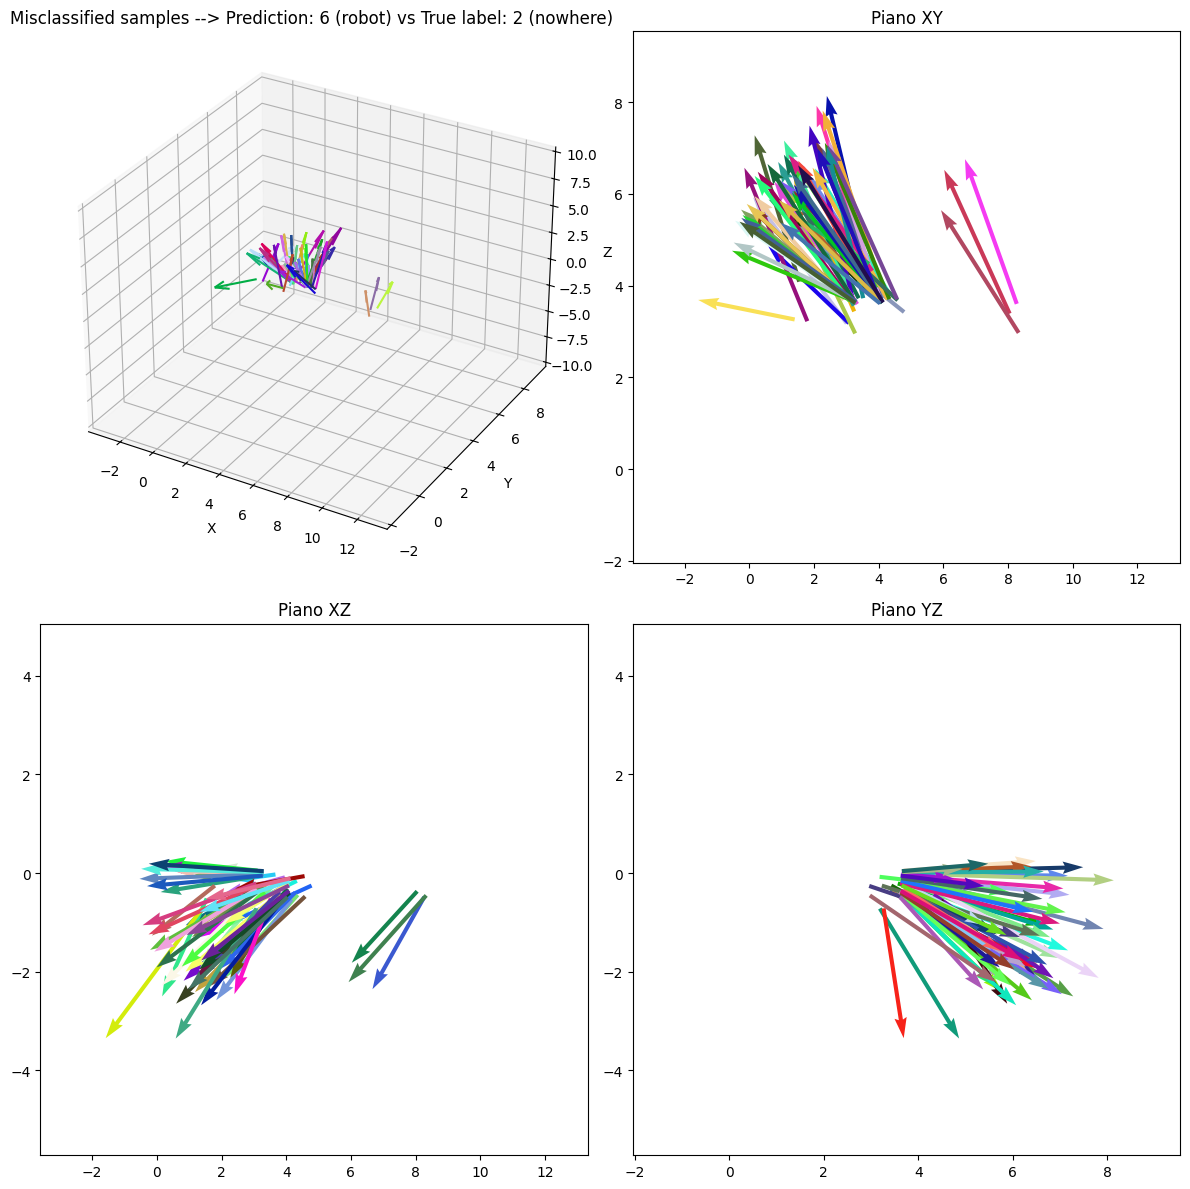

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Funzione per calcolare il vettore del gaze
def gaze_vector(azimuth, elevation, origin=(0, 0, 0), length=1):
    # Calcola le componenti del vettore
    x = length * np.cos(elevation) * np.sin(azimuth)
    y = length * np.cos(elevation) * np.cos(azimuth)
    z = length * np.sin(elevation)

    return np.array([x, y, z])

# Sostituisci con il tuo valore per la label desiderata
# selected_label = 1  # Sostituisci con la classe che vuoi visualizzare

# Filtra i dati per la classe selezionata
filtered_data = X_test.iloc[mis]

# Pulizia dei dati (eliminare NaN e Inf)
# filtered_data = filtered_data.replace([np.inf, -np.inf], np.nan).dropna()

# Calcola il centro del grafico
center = np.mean(filtered_data[['eyes_x', 'eyes_y']], axis=0)

# Crea il grafico 3D
fig = plt.figure(figsize=(12, 12))

# PLOT 3D
ax = fig.add_subplot(221, projection='3d')  # Grafico 3D principale
for i in range(len(filtered_data)):
    position = [filtered_data.iloc[i]['eyes_x'] / 100,  # Ridotto per visibilità
                filtered_data.iloc[i]['eyes_y'] / 100, 0]  # Ridotto per visibilità

    azimuth = filtered_data.iloc[i]['azimuth']
    elevation = filtered_data.iloc[i]['elevation']

    # Aumenta la lunghezza del vettore per visibilità
    length = 4  # Lunghezza del vettore ridotta
    gaze = gaze_vector(azimuth, elevation, origin=position, length=length)  # Modifica la lunghezza del vettore

    # Assegna un colore random per ogni freccia nel 3D
    color = np.random.rand(3,)  # Colore casuale (RGB)

    ax.quiver(position[0], position[1], position[2], gaze[0], gaze[1], gaze[2], length=1, normalize=False, color=color)

# Impostazioni automatiche degli assi con zoom out
ax.set_xlim([filtered_data['eyes_x'].min() / 100 - 5, filtered_data['eyes_x'].max() / 100 + 5])
ax.set_ylim([filtered_data['eyes_y'].min() / 100 - 5, filtered_data['eyes_y'].max() / 100 + 5])
ax.set_zlim([-10, 10])  # Maggiore range per la visualizzazione
ax.set_title('Misclassified samples --> Prediction: 6 (robot) vs True label: 2 (nowhere) ')

# Etichette degli assi
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


# Piani XY, XZ, YZ
# PLOT XY
ax_xy = fig.add_subplot(222)  # Piano XY
for i in range(len(filtered_data)):
    position = [filtered_data.iloc[i]['eyes_x'] / 100, filtered_data.iloc[i]['eyes_y'] / 100]
    azimuth = filtered_data.iloc[i]['azimuth']
    elevation = filtered_data.iloc[i]['elevation']

    # Calcola il vettore del gaze
    gaze = gaze_vector(azimuth, elevation, origin=position, length=length)

    # Assegna un colore random per ogni freccia
    color = np.random.rand(3,)  # Colore casuale (RGB)

    # Aggiungi la freccia nel piano XY (proietta su X e Y)
    ax_xy.quiver(position[0], position[1], gaze[0], gaze[1], angles='xy', scale_units='xy', scale=1, color=color)

# Impostazioni di zoom out sugli assi
ax_xy.set_xlim([filtered_data['eyes_x'].min() / 100 - 5, filtered_data['eyes_x'].max() / 100 + 5])
ax_xy.set_ylim([filtered_data['eyes_y'].min() / 100 - 5, filtered_data['eyes_y'].max() / 100 + 5])
ax_xy.set_title('Piano XY')

# PLOT XZ
ax_xz = fig.add_subplot(223)  # Piano XZ
for i in range(len(filtered_data)):
    position = [filtered_data.iloc[i]['eyes_x'] / 100, filtered_data.iloc[i]['elevation']]
    azimuth = filtered_data.iloc[i]['azimuth']
    elevation = filtered_data.iloc[i]['elevation']

    # Calcola il vettore del gaze
    gaze = gaze_vector(azimuth, elevation, origin=position, length=length)

    # Assegna un colore random per ogni freccia
    color = np.random.rand(3,)  # Colore casuale (RGB)

    # Aggiungi la freccia nel piano XZ (proietta su X e Z)
    ax_xz.quiver(position[0], position[1], gaze[0], gaze[2], angles='xy', scale_units='xy', scale=1, color=color)

# Impostazioni di zoom out sugli assi
ax_xz.set_xlim([filtered_data['eyes_x'].min() / 100 - 5, filtered_data['eyes_x'].max() / 100 + 5])
ax_xz.set_ylim([filtered_data['elevation'].min() - 5, filtered_data['elevation'].max() + 5])
ax_xz.set_title('Piano XZ')

# PLOT YZ
ax_yz = fig.add_subplot(224)  # Piano YZ
for i in range(len(filtered_data)):
    position = [filtered_data.iloc[i]['eyes_y'] / 100, filtered_data.iloc[i]['elevation']]
    azimuth = filtered_data.iloc[i]['azimuth']
    elevation = filtered_data.iloc[i]['elevation']

    # Calcola il vettore del gaze
    gaze = gaze_vector(azimuth, elevation, origin=position, length=length)

    # Assegna un colore random per ogni freccia
    color = np.random.rand(3,)  # Colore casuale (RGB)

    # Aggiungi la freccia nel piano YZ (proietta su Y e Z)
    ax_yz.quiver(position[0], position[1], gaze[1], gaze[2], angles='xy', scale_units='xy', scale=1, color=color)

# Impostazioni di zoom out sugli assi
ax_yz.set_xlim([filtered_data['eyes_y'].min() / 100 - 5, filtered_data['eyes_y'].max() / 100 + 5])
ax_yz.set_ylim([filtered_data['elevation'].min() - 5, filtered_data['elevation'].max() + 5])
ax_yz.set_title('Piano YZ')

# Mostra il grafico
plt.tight_layout()
plt.show()
